In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2
import re
import zipfile
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/deep_fake.zip'
destination_directory = '/content/deep_fake'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

# Print confirmation message
print("Unzipping complete!")

Unzipping complete!


In [ ]:
import random
dataset_dir = '/content/deep_fake/Dataset/Train/Real'
folder = dataset_dir

random_img_path = os.path.join(folder, random.choice(os.listdir(folder)))
print("Random image size before preprocessing:", Image.open(random_img_path).size)


Random image size before preprocessing: (256, 256)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root="/content/deep_fake/Dataset/Train", transform=data_transform)


In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numeric values (0 or 1)
encoded_labels = label_encoder.fit_transform(dataset.classes)

# Print the encoded labels
print(encoded_labels)

[0 1]


In [ ]:
from torch.utils.data import Subset

# Separate samples by class
real_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Real"]
fake_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Fake"]

# Randomly sample 20,000 samples from each class
real_samples = np.random.choice(real_samples, 25000, replace=False)
fake_samples = np.random.choice(fake_samples, 25000, replace=False)

# Combine the sampled indices
filtered_indices = np.concatenate([real_samples, fake_samples])
filtered_samples = [dataset.samples[idx] for idx in filtered_indices]

# Create a Subset dataset using the filtered samples
filtered_dataset = Subset(dataset, filtered_indices)

In [ ]:
print(len(filtered_dataset))

50000


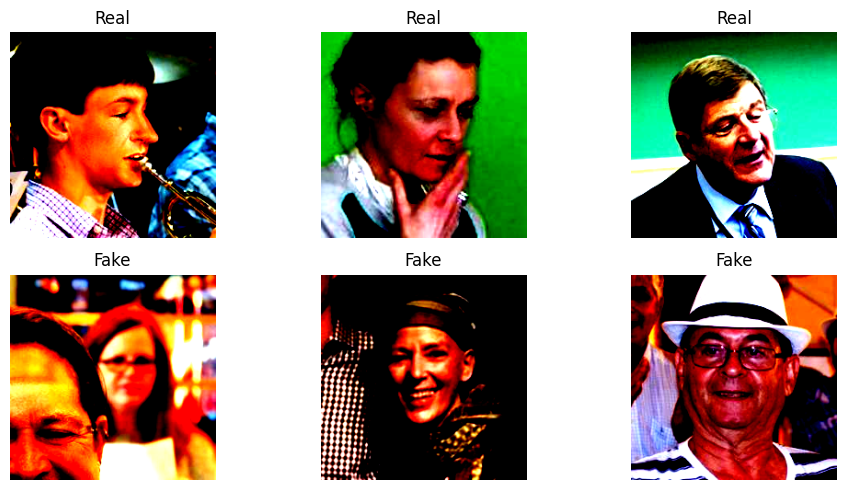

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of images to display from each class
num_images_per_class = 3

# Initialize counters for the number of displayed images from each class
real_count = 0
fake_count = 0

# Create subplots for displaying the images
fig, axs = plt.subplots(2, num_images_per_class, figsize=(10, 5))

# Iterate through the dataset and display the images
for image, label in filtered_dataset:
    # Convert the image tensor to a NumPy array and transpose it to the correct shape
    image = image.permute(1, 2, 0).numpy()

    # Check if the current image belongs to the "real" class and display it if the count is less than num_images_per_class
    if label == 0 and real_count < num_images_per_class:
        axs[0, real_count].imshow(image)
        axs[0, real_count].axis('off')
        axs[0, real_count].set_title('Real')
        real_count += 1

    # Check if the current image belongs to the "fake" class and display it if the count is less than num_images_per_class
    elif label == 1 and fake_count < num_images_per_class:
        axs[1, fake_count].imshow(image)
        axs[1, fake_count].axis('off')
        axs[1, fake_count].set_title('Fake')
        fake_count += 1

    # Break the loop if the desired number of images has been displayed from both classes
    if real_count >= num_images_per_class and fake_count >= num_images_per_class:
        break

plt.tight_layout()
plt.show()

In [ ]:
dataset = filtered_dataset
# Define sizes for train, validation, and test sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train, validation, and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
vali_size = int(0.11112*len(train_set))
train_size = len(train_set) - vali_size
train_set, vali_set = torch.utils.data.random_split(train_set, [train_size, vali_size])

# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32,shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=32,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32,shuffle=True)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*5*5, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = AlexNet()

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

cuda


In [ ]:
def train_and_validate(model, train_loader, vali_loader, device, num_epochs):
    train_losses, train_accuracies = [], []
    validation_losses, validation_accuracies = [], []
    train_predictions = []
    vali_predictions = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_predicted_true = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predictions = torch.sigmoid(outputs)

            predictions[outputs > 0.5] = 1.0
            predictions[outputs <= 0.5] = 0.0
            for i in range(len(predictions)):
              if predictions[i] == labels[i]:
                train_predicted_true += 1
            # Convert sigmoid outputs to binary predictions
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_predicted_true*100 / len(train_set))

        # Validation
        model.eval()
        vali_loss = 0
        vali_predicted_true = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vali_loader:
                inputs, labels = inputs.to(device),labels.float().to(device)
                outputs = model(inputs)
                vali_loss += criterion(outputs.squeeze(), labels).item()
                vali_predictions = torch.sigmoid(outputs)
                vali_predictions[outputs > 0.5] = 1.0
                vali_predictions[outputs <= 0.5] = 0.0
                for i in range(len(vali_predictions)):
                  if vali_predictions[i] == labels[i]:
                    vali_predicted_true += 1

                total_val += labels.size(0)

        vali_loss_epoch = vali_loss / len(vali_loader)
        vali_acc_epoch = vali_predicted_true*100 / len(vali_set)
        validation_losses.append(vali_loss_epoch)
        validation_accuracies.append(vali_acc_epoch)

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Validation Loss: {validation_losses[-1]:.4f}, Accuracy: {validation_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


In [ ]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
    model=model,
    train_loader=train_loader,
    vali_loader=vali_loader,
    device=device,
    num_epochs=10)

Epoch 1/10
Training Loss: 0.4394, Accuracy: 76.9325
Validation Loss: 0.2909, Accuracy: 83.9400
Epoch 2/10
Training Loss: 0.2134, Accuracy: 90.5550
Validation Loss: 0.1626, Accuracy: 91.7000
Epoch 3/10
Training Loss: 0.1510, Accuracy: 93.4950
Validation Loss: 0.1305, Accuracy: 94.4000
Epoch 4/10
Training Loss: 0.1191, Accuracy: 95.0050
Validation Loss: 0.1945, Accuracy: 93.5000
Epoch 5/10
Training Loss: 0.0990, Accuracy: 95.8975
Validation Loss: 0.1137, Accuracy: 94.9600
Epoch 6/10
Training Loss: 0.0823, Accuracy: 96.5700
Validation Loss: 0.1738, Accuracy: 94.5200
Epoch 7/10
Training Loss: 0.0708, Accuracy: 96.9350
Validation Loss: 0.1063, Accuracy: 95.6000
Epoch 8/10
Training Loss: 0.0598, Accuracy: 97.3875
Validation Loss: 0.1072, Accuracy: 95.7800
Epoch 9/10
Training Loss: 0.0496, Accuracy: 97.9175
Validation Loss: 0.1152, Accuracy: 95.8400
Epoch 10/10
Training Loss: 0.0457, Accuracy: 98.1000
Validation Loss: 0.1062, Accuracy: 95.8000


In [ ]:
def test(model):
  correct_test = 0
  test_loss = 0
  total_test=0
  test_predictions = []
  labels_test_total = []
  test_predicted_true = 0
  with torch.no_grad():
    for inputs, labels_test in test_loader:
        inputs,labels_test = inputs.to(device), labels_test.float().to(device)
        test_output = model(inputs)
        loss = criterion(test_output.squeeze(), labels_test)
        test_loss += loss.item()
        predicted_test_classes = torch.sigmoid(test_output)
        predicted_test_classes_modified = predicted_test_classes.clone()
        predicted_test_classes_modified[test_output > 0.5] = 1.0
        predicted_test_classes_modified[test_output <= 0.5] = 0.0
        for i in range(len(predicted_test_classes_modified)):
          if predicted_test_classes_modified[i] == labels_test[i]:
            test_predicted_true += 1
        total_test += labels_test.size(0)
        test_predictions.extend(predicted_test_classes_modified)
        labels_test_total.extend(labels_test)

  test_loss = test_loss / len(test_loader)
  test_accuracy = 100 * test_predicted_true / len(test_set)

  print(f"Test Accuracy: {test_accuracy:.2f}%")
  print(f"Test Loss: {test_loss:.4f}")

  return labels_test_total, test_predictions, predicted_test_classes, test_loss, test_accuracy


In [ ]:
test_labels, test_predictions, predicted_test_classes, test_loss, test_accuracy = test(model)

Test Accuracy: 95.78%
Test Loss: 0.1054


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns

def metrics(labels_test_total, predicted_test_classes, test_probabilities, test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies):

    # Move tensors to CPU and detach from the computation graph
    labels_test_cpu = [labels.cpu() for labels in labels_test_total]
    predicted_test_classes_cpu = [predictions.cpu() for predictions in predicted_test_classes]
    test_probabilities_cpu = test_probabilities.cpu().detach().numpy()
    test_loss_cpu = test_loss

    accuracy = accuracy_score(labels_test_cpu, predicted_test_classes_cpu)
    precision = precision_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    recall = recall_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    f1Score = f1_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    classify_report = classification_report(labels_test_cpu, predicted_test_classes_cpu)

    # Print classification metrics
    print("Accuracy:", accuracy)
    print("precision_score: ", precision)
    print("recall_score: ", recall)
    print("f1_score: ", f1Score)
    print("Classification Report:")
    print(classify_report)

    # Plot loss and accuracy curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(validation_losses, label='Validation Loss')
    ax1.axhline(y=test_loss_cpu, color='r', linestyle='--', label='Test Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(validation_accuracies, label='Validation Accuracy')
    ax2.axhline(y=accuracy, color='r', linestyle='--', label='Test Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test_cpu, predicted_test_classes_cpu)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.9578
precision_score:  0.9578
recall_score:  0.9578
f1_score:  0.9578
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2489
         1.0       0.97      0.95      0.96      2511

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



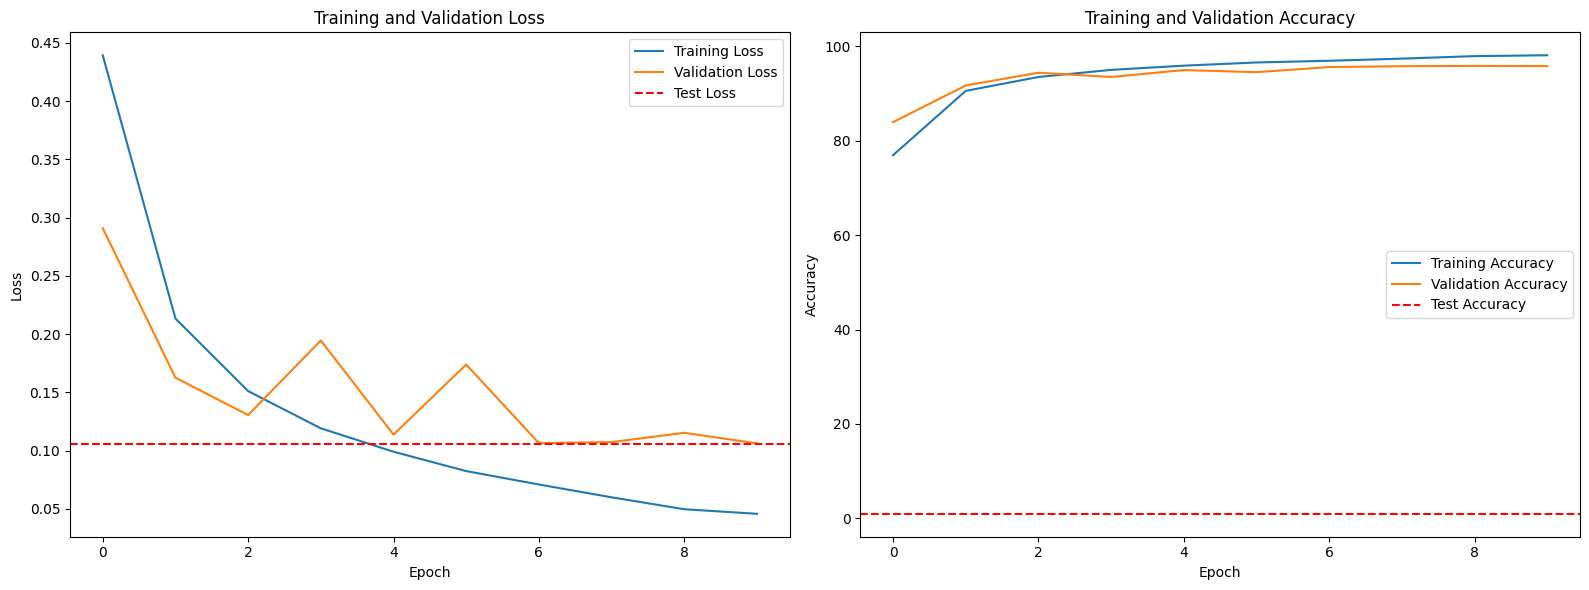

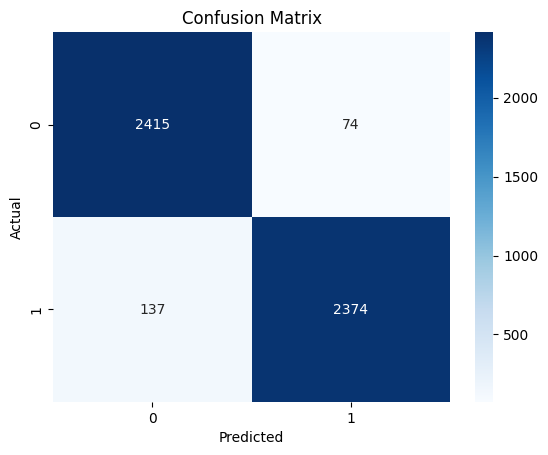

In [ ]:
metrics(test_labels, test_predictions, predicted_test_classes.cpu(), test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies)

In [ ]:
def train_and_validate_1(model, train_loader, vali_loader, device, num_epochs, l2_shceduler, early_stopping=None,early_stop=False):
    train_losses, train_accuracies = [], []
    validation_losses, validation_accuracies = [], []
    train_predictions = []
    vali_predictions = []
    best_val_accuracy = 0
    l = 0
    epochs_completed = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_predicted_true = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            if l2_shceduler:
              l2loss = 0.0
              for i in model.parameters():
                l2loss = l2loss + torch.norm(i)
              loss = loss + (l*l2loss)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predictions = torch.sigmoid(outputs)

            predictions[outputs > 0.5] = 1.0
            predictions[outputs <= 0.5] = 0.0
            for i in range(len(predictions)):
              if predictions[i] == labels[i]:
                train_predicted_true += 1
            # Convert sigmoid outputs to binary predictions
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_predicted_true*100 / len(train_set))

        # Validation
        model.eval()
        vali_loss = 0
        vali_predicted_true = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vali_loader:
                inputs, labels = inputs.to(device),labels.float().to(device)
                outputs = model(inputs)
                vali_loss += criterion(outputs.squeeze(), labels).item()
                vali_predictions = torch.sigmoid(outputs)
                vali_predictions[outputs > 0.5] = 1.0
                vali_predictions[outputs <= 0.5] = 0.0
                for i in range(len(vali_predictions)):
                  if vali_predictions[i] == labels[i]:
                    vali_predicted_true += 1

                total_val += labels.size(0)

        vali_loss_epoch = vali_loss / len(vali_loader)
        vali_acc_epoch = vali_predicted_true*100 / len(vali_set)
        validation_losses.append(vali_loss_epoch)
        validation_accuracies.append(vali_acc_epoch)

        if vali_acc_epoch > best_val_accuracy:
            best_val_accuracy = vali_acc_epoch
            epochs_completed = 0
        else:
            epochs_completed += 1

        if early_stop:
          if early_stopping and epochs_completed >= early_stopping:
              print(f'Early stopping triggered')
              early_stop = True
              break

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Validation Loss: {validation_losses[-1]:.4f}, Accuracy: {validation_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


L2 Regularization

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_1 = AlexNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

cuda


In [ ]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate_1(
    model=model_1,
    train_loader=train_loader,
    vali_loader=vali_loader,
    device=device,
    num_epochs=10,
    l2_shceduler=True)

Epoch 1/10
Training Loss: 0.4507, Accuracy: 76.1925
Validation Loss: 0.3494, Accuracy: 86.0000
Epoch 2/10
Training Loss: 0.2155, Accuracy: 90.7675
Validation Loss: 0.1995, Accuracy: 89.5400
Epoch 3/10
Training Loss: 0.1557, Accuracy: 93.4175
Validation Loss: 0.1735, Accuracy: 92.5600
Epoch 4/10
Training Loss: 0.1238, Accuracy: 94.7825
Validation Loss: 0.1212, Accuracy: 95.3000
Epoch 5/10
Training Loss: 0.1010, Accuracy: 95.8325
Validation Loss: 0.1294, Accuracy: 95.3800
Epoch 6/10
Training Loss: 0.0851, Accuracy: 96.4575
Validation Loss: 0.1117, Accuracy: 95.4000
Epoch 7/10
Training Loss: 0.0710, Accuracy: 96.9875
Validation Loss: 0.1641, Accuracy: 91.5400
Epoch 8/10
Training Loss: 0.0614, Accuracy: 97.3125
Validation Loss: 0.1294, Accuracy: 95.4400
Epoch 9/10
Training Loss: 0.0545, Accuracy: 97.7375
Validation Loss: 0.1331, Accuracy: 94.9600
Epoch 10/10
Training Loss: 0.0454, Accuracy: 98.0925
Validation Loss: 0.1219, Accuracy: 96.2000


In [ ]:
test_labels, test_predictions, predicted_test_classes, test_loss, test_accuracy = test(model_1)

Test Accuracy: 95.78%
Test Loss: 0.1252


Accuracy: 0.9578
precision_score:  0.9578
recall_score:  0.9578
f1_score:  0.9578
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      2525
         1.0       0.94      0.97      0.96      2475

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



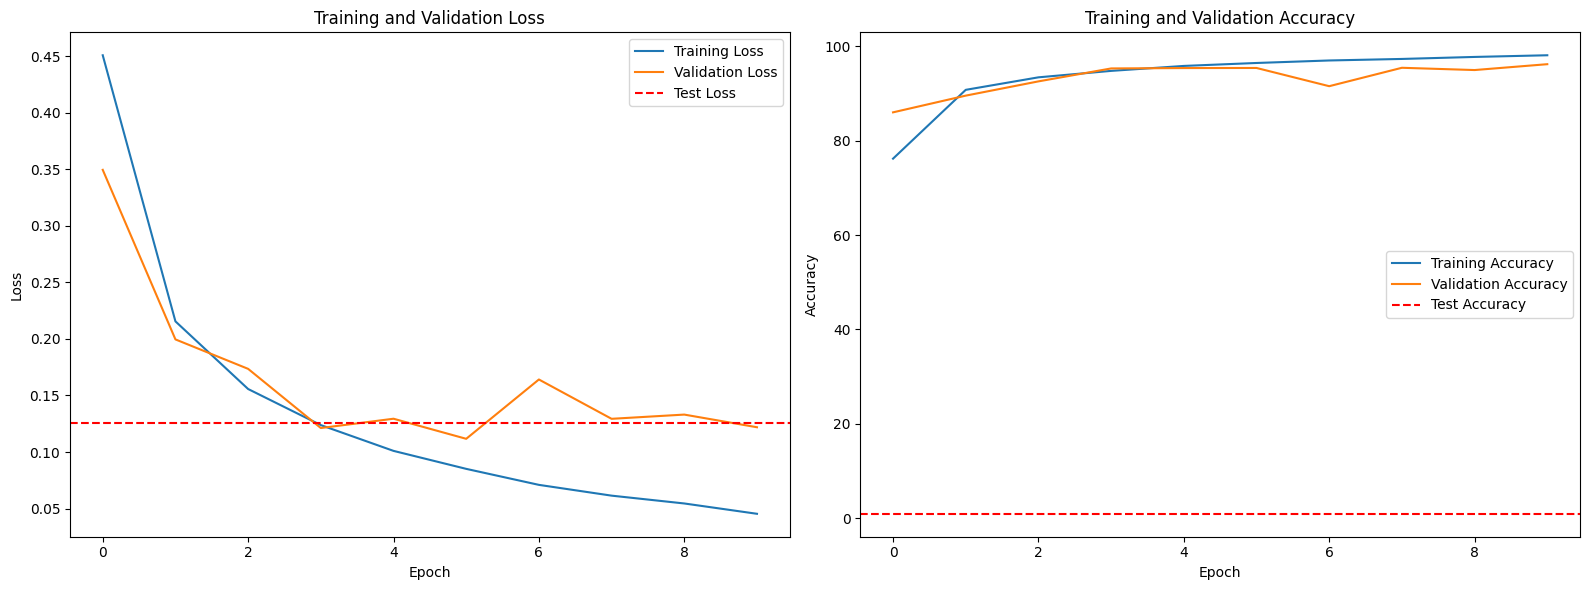

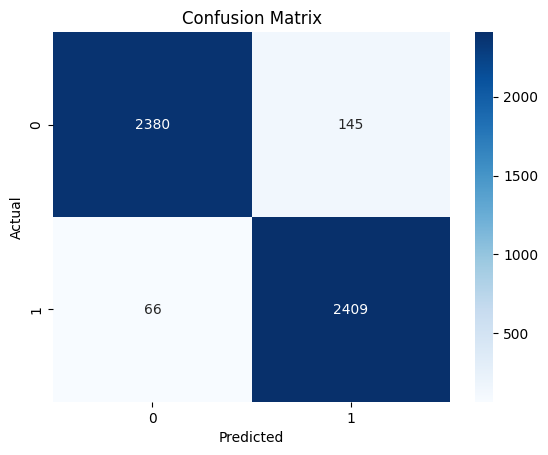

In [ ]:
metrics(test_labels, test_predictions, predicted_test_classes.cpu(), test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies)

Early Stopping

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_2 = AlexNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

cuda


In [ ]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate_1(
    model=model_2,
    train_loader=train_loader,
    vali_loader=vali_loader,
    device=device,
    num_epochs=10,
    l2_shceduler=True,
    early_stopping=4,early_stop=True)

Epoch 1/10
Training Loss: 0.4562, Accuracy: 76.0875
Validation Loss: 0.5018, Accuracy: 82.6200
Epoch 2/10
Training Loss: 0.2230, Accuracy: 90.3275
Validation Loss: 0.1787, Accuracy: 92.0000
Epoch 3/10
Training Loss: 0.1557, Accuracy: 93.3575
Validation Loss: 0.1918, Accuracy: 93.6000
Epoch 4/10
Training Loss: 0.1211, Accuracy: 94.8275
Validation Loss: 0.1833, Accuracy: 89.3800
Epoch 5/10
Training Loss: 0.1039, Accuracy: 95.5200
Validation Loss: 0.1101, Accuracy: 95.6200
Epoch 6/10
Training Loss: 0.0846, Accuracy: 96.4150
Validation Loss: 0.1312, Accuracy: 94.3400
Epoch 7/10
Training Loss: 0.0695, Accuracy: 96.9725
Validation Loss: 0.1114, Accuracy: 96.2600
Epoch 8/10
Training Loss: 0.0629, Accuracy: 97.3300
Validation Loss: 0.1108, Accuracy: 95.6400
Epoch 9/10
Training Loss: 0.0518, Accuracy: 97.7650
Validation Loss: 0.1830, Accuracy: 94.0000
Epoch 10/10
Training Loss: 0.0495, Accuracy: 97.9450
Validation Loss: 0.1140, Accuracy: 95.1400


In [ ]:
test_labels, test_predictions, predicted_test_classes, test_loss, test_accuracy = test(model_2)

Test Accuracy: 94.58%
Test Loss: 0.1362


Accuracy: 0.9458
precision_score:  0.9458
recall_score:  0.9458
f1_score:  0.9458
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95      2525
         1.0       0.97      0.92      0.94      2475

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



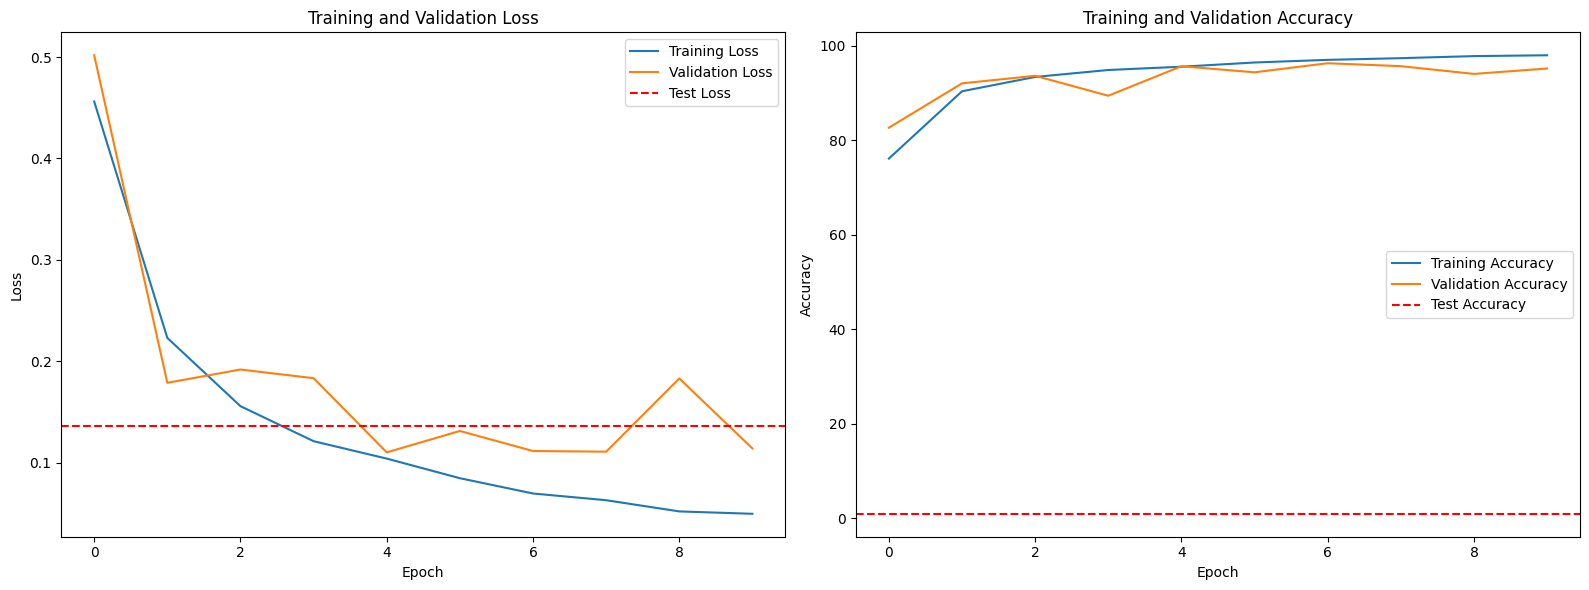

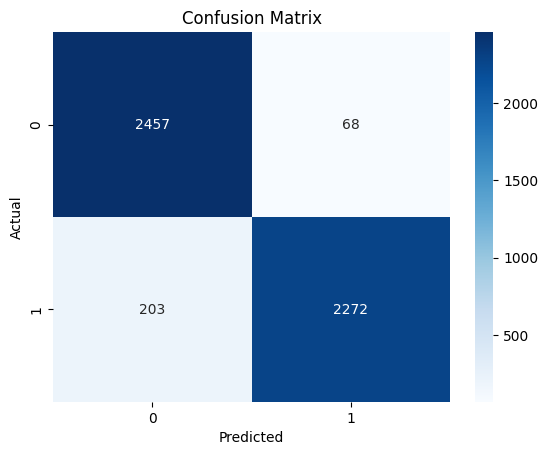

In [ ]:
metrics(test_labels, test_predictions, predicted_test_classes.cpu(), test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies)